In [146]:
import numpy as np
import pandas as pd
import opendssdirect as dss
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook, tqdm
import btrdb as db
import uuid
from btrdb.utils.timez import datetime_to_ns
import simulation_utils as sims
from datetime import datetime, timedelta

%matplotlib inline

import importlib

importlib.reload(sims);

In [147]:
# Connect to the database
conn = db.connect(profile="collab")

In [148]:
model_loc = "./Models/13Bus/IEEE13Nodeckt.dss"
dss.run_command("Redirect " + model_loc);

# Create output streams
The following cells create the output streams or retrieve them if they have already been created. 

In [149]:
prefix = "simulated/ieee13"
collections, names, tags, annotations = sims.get_stream_info(base_col=prefix)

In [ ]:
nstreams = len(collections)
print("Creating", nstreams, "streams")
for i in range(nstreams):
    print(collections[i] + "/" + names[i])

In [151]:
streams_dict = sims.create_streams(prefix, collections, names, tags, annotations, conn)

Found 234 streams under simulated/ieee13
Found 234 streams. Created 0 streams.


## Generate simulated measurements
The following cell generates data that will be converted into streams. 
For convenience, we back-calculate the number of samples from a user specified sample rate (`fs`) and simulation duration (`start_time` to `end_time`). However, keep in mind that the simulation has no inherent sense of time - we are abitrarily assigning timestamps to each simulation result. 

In [152]:
# The number of samples to generate
start_time = datetime(2022, 1, 1, 0, 0, 0)
end_time = datetime(2022, 1, 1, 0, 1, 0)
fs = 30  # Hz
T = int(((end_time - start_time).total_seconds()) * fs)
print("We will generate", T, "samples.")

# Generate the nanosecond timestamps for the data
start_ns = datetime_to_ns(start_time)
end_ns = datetime_to_ns(end_time)
timestamps = np.arange(start_ns, end_ns, 1e9 / 30, dtype="int")

We will generate 1800 samples.


In [153]:
# Get the original loads
load, load_names = sims.get_loads()
nloads = len(load_names)

# Generate the randomized scaling factors
mu = 1.1
sig = 0.1
s = np.random.normal(loc=mu, scale=sig, size=[nloads, T])

# Generate the new load values
new_load = s * load[:, np.newaxis]

In [154]:
V, I = sims.simulate_network(new_load, load_names)

Running simulation:   0%|          | 0/1799 [00:00<?, ?it/s]

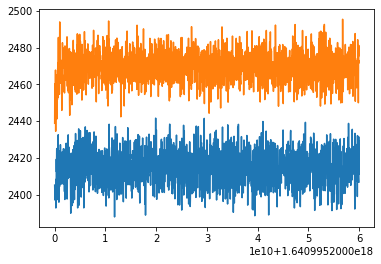

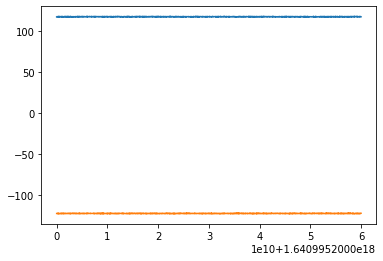

In [155]:
plt.plot(timestamps, V["646/VCM"])
plt.plot(timestamps, V["646/VBM"])

plt.figure()
plt.plot(timestamps, V["646/VCA"])
plt.plot(timestamps, V["646/VBA"])

In [156]:
print("Number of streams simulated:")
print(len(V.keys()) + len(I.keys()))

Number of streams simulated:
234


# Push data to streams

In [ ]:
# Put voltage data into the corresponding stream
sims.add_all_data(timestamps, V, streams_dict, prefix)
# Put current data into the corresponding stream
sims.add_all_data(timestamps, I, streams_dict, prefix)

# Add long period of data
The following cell runs a loop which will generate and push data over a much longer period. 
The purpose of the loop is to avoid generating all the data at once - instead, the full time period is divided into smaller time chunks, with data generated and inserted for each chunk sequentially. 

The code is divided into two cells below - the first is the initialization step. The second runs the loop. If there is an error during the loop, the second cell can be re-run and will pick up where it left off. 

In [ ]:
# Collection prefix in which data will be added
prefix = "simulated/ieee13"
# Get the desired output streams to which data will be pushed
collections, names, tags, annotations = sims.get_stream_info(base_col=prefix)
# If the desired streams exist, retrieve them. Otherwise create them.
streams_dict = sims.create_streams(prefix, collections, names, tags, annotations, conn)


# Get the original loads
load, load_names = sims.get_loads()
nloads = len(load_names)

# Simulation time window - the FULL time range over which we want to generate data
start_time = datetime(2022, 1, 2, 0, 0, 0)
end_time = datetime(2022, 1, 3, 0, 0, 0)
fs = 30  # Hz
Ttotal = int(((end_time - start_time).total_seconds()) * fs)
print("We will generate", Ttotal, "samples.")

# The simulation time step - this is the amount of data we insert at once.
step = timedelta(minutes=5)
nsteps = int((end_time - start_time) / step)

# Create progress bar
pbar = tqdm(total=nsteps, desc="Adding simulated data")

t0 = start_time

In [145]:
remaining_steps = int((end_time - t0) / step)
pbar = tqdm(total=remaining_steps, desc="Adding simulated data")
while t0 < end_time:
    # Generate the nanosecond timestamps for the data
    t0_ns = datetime_to_ns(t0)
    t1_ns = datetime_to_ns(t0 + step)
    timestamps = np.arange(t0_ns, t1_ns, 1e9 / fs, dtype="int")

    # The number of samples to be generated in this iteration
    T = len(timestamps)
    # Generate the randomized scaling factors
    mu = 1.1
    sig = 0.1
    s = np.random.normal(loc=mu, scale=sig, size=[nloads, T])
    # Generate the new load values
    new_load = s * load[:, np.newaxis]
    # Simulate
    V, I = sims.simulate_network(new_load, load_names)

    # Push data to database
    # Put voltage data into the corresponding stream
    sims.add_all_data(timestamps, V, streams_dict, prefix)
    # Put current data into the corresponding stream
    sims.add_all_data(timestamps, I, streams_dict, prefix)

    # Increment time
    t0 = t0 + step
    pbar.update(1)
pbar.close()

Adding simulated data:   0%|          | 0/110 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

Running simulation:   0%|          | 0/8999 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/82 [00:00<?, ?it/s]

Pushing data to streams:   0%|          | 0/152 [00:00<?, ?it/s]

# DELETING streams
**DO NOT RUN** unless you are certain you want to delete. 

In [120]:
prefix = "simulated/ieee13"
# Get the desired output streams to which data will be pushed
collections, names, tags, annotations = sims.get_stream_info(base_col=prefix)
# If the desired streams exist, retrieve them. Otherwise create them.
streams_dict = sims.create_streams(prefix, collections, names, tags, annotations, conn)

for key, val in streams_dict.items():
    print("Deleting", key)
    ### val.obliterate() ## UNCOMMENT IF YOU WANT TO DELETE

Found 234 streams under simulated/ieee13
Found 234 streams. Created 0 streams.
